In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tqdm import tqdm

df = pd.read_csv('../data/graph_train.csv')
print(df[['graph_id', 'benchmark']].head())
y = pd.cut(df['edge_cross_norm'], bins=[-1,-1e-10,1]).to_numpy()
df = df.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','Unnamed: 0'],axis=1)
list_columns = list(df)

for col in list_columns:
    print(col)
    if col!= 'edge_cross_norm' and col!= 'is_bridge':
        df[col] = pd.qcut(df[col],q=5)

X = df.to_numpy()

classifier = XGBClassifier()
classifier.load_model('xgb.bin')

   graph_id   benchmark
0         0  random-dag
1         0  random-dag
2         0  random-dag
3         0  random-dag
4         0  random-dag
edge_betweenness
stress
is_bridge
diff_stress
diff_cross
diff_edgelength
exp_factor_norm
sum_neighbour_deg_norm
max_neighbour_deg_norm
grad_diff


In [2]:
from src.graph_parser import parseGraphmlFile
import os

def read_list_of_graphs(dir_name,ext):
    list_graphs = [parseGraphmlFile(dir_name+f,weighted=False,directed=False) for f in os.listdir(dir_name) if f.endswith('.' + ext)]
    return list_graphs

graph_lists = {
    'random-dag': read_list_of_graphs(f'../data/random-dag/','graphml'),
    'rome': read_list_of_graphs(f'../data/rome/','graphml'),
    'north': read_list_of_graphs(f'../data/north/','graphml')
}

In [3]:
from src.graph_utils import compareGraphs
import networkx as nx


def compareRelaxedDrawing(graph_id, bench, classifier, draw_f, thresh=0.5, debug=False):
    g = graph_lists[bench][graph_id]
    pos1 = draw_f(g)

    g_df = pd.read_csv('../data/graph_train.csv')
    g_df = g_df[(g_df.graph_id == graph_id) & (g_df.benchmark == bench)].reset_index(drop=True)
    g_df = g_df.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','Unnamed: 0','diff_cross'],axis=1)

    y_pred = classifier.predict_proba(g_df.to_numpy())[:, 1]
    edges2rm = np.where(y_pred>thresh)[0]
    g_copy = g.copy()
    g_copy.remove_edges_from([list(g.edges())[idx] for idx in edges2rm])

    pos2 = draw_f(g_copy)

    if debug:
        print(f"Removed edges: {len(edges2rm)}")

    return compareGraphs(g, g, pos1, pos2, show=debug)

Removed edges: 2
           Num crossings: 6 - 3 (✅ -3.0)
            Aspect ratio: 0.890 - 0.612 (❌ -0.278)
     Mean crossing angle: 60.476 - 75.206 (✅ 14.730)
Pseudo vertex resolution: 0.276 - 0.189 (❌ -0.088)
 Mean angular resolution: inf - inf (🟡 nan)


/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:421: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)


array([-3.        , -0.27775141, 14.73014257, -0.08792554,         nan,
       -0.07023381,  0.02068187])

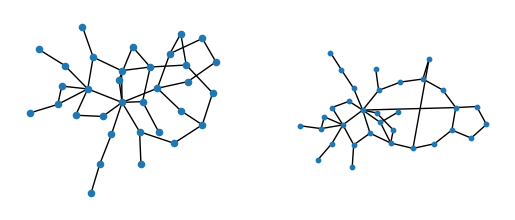

In [4]:
draw_f = lambda gg: nx.kamada_kawai_layout(gg, pos=nx.spectral_layout(gg))
compareRelaxedDrawing(3, 'rome', classifier, draw_f, debug=True, thresh=0.7)


In [5]:
n = 50
thresh_vals = [0.5, 0.6, 0.7, 0.8, 0.9]
thresh_labels = [f'thresh_{val}' for val in thresh_vals]

values = []

for graph_id in tqdm(range(n)):
    row = []
    for thresh in thresh_vals:
        cross_val = compareRelaxedDrawing(graph_id, 'rome', classifier, draw_f, debug=False, thresh=thresh)[0]
        row.append(cross_val)
    values.append(row)

values = pd.DataFrame(values, columns=thresh_labels)

values

  0%|          | 0/50 [00:00<?, ?it/s]/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:421: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)
/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:421: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)
/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:421: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)
/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:421: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)
/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:421: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)
  2%|▏         | 1/50 [00:01<00:52,  1.08s/it]/Users/raulhigueras/Desktop/Research

,thresh_0.5,thresh_0.6,thresh_0.7,thresh_0.8,thresh_0.9
0,4.0,4.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,9.0,0.0,0.0,0.0,0.0
3,9.0,-1.0,-3.0,0.0,0.0
4,8.0,7.0,0.0,0.0,0.0
5,-70.0,8.0,-14.0,-25.0,0.0
6,-41.0,13.0,5.0,0.0,0.0
7,27.0,-4.0,-3.0,-1.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,20.0,3.0,0.0,0.0,0.0


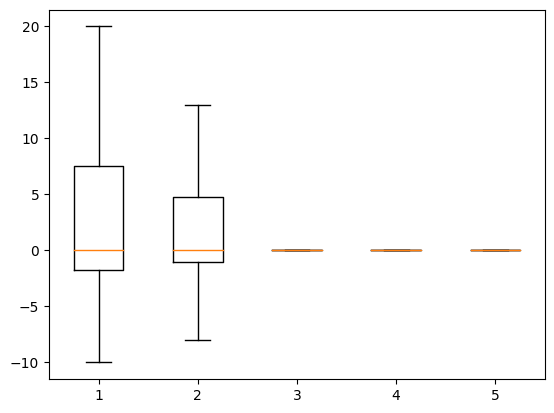

In [6]:
plt.boxplot(values, showfliers=False);